In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
data = pd.read_csv("./dataset.csv")
df = data.copy()
df.drop(['id'], axis=1,inplace = True)
def count_na(df):
  series = df.isna().sum()
  return series[series > 0]
s = count_na(df)
s

radius_mean        1
perimeter_mean     1
concavity_mean     1
compactness_se     1
area_worst         2
concavity_worst    1
dtype: int64

In [3]:
def normpdf(x, mean, var):
    
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [4]:
def fisher_linear_discriminant(df):
    
   
    
    # Select ratio
    ratio = 0.67

    total_rows = df.shape[0]
    train_size = int(total_rows*ratio)

    # Split data into test and train
    train = df[0:train_size].copy()
    test = df[train_size:].copy()
    
    s = count_na(train)
    for i in s.index:
        train[i].fillna(value = train[i].mean(),inplace = True)
    s = count_na(test)
    for i in s.index:
        test[i].fillna(value = test[i].mean(),inplace = True)
    
    features = df.columns.tolist()

    features.remove('diagnosis')

    for i in features:
        train[i] = (train[i] - train[i].mean()) / train[i].std()
        test[i] = (test[i] - test[i].mean()) / test[i].std()
    
    
    dfB = train[train["diagnosis"] == "B"].copy()
    dfM = train[train["diagnosis"] == "M"].copy()

    dfB.drop(['diagnosis'], axis=1,inplace = True)
    dfM.drop(['diagnosis'], axis=1,inplace = True)
    
    
    
    matrixB = dfB.to_numpy()
    matrixM = dfM.to_numpy()
    matrixB = matrixB[..., np.newaxis]
    matrixM = matrixM[..., np.newaxis]
    

    meanB = np.zeros(matrixB[0].shape,dtype = np.float64)
    meanM = np.zeros(matrixM[0].shape,dtype = np.float64)
    for i in range(30):
        meanB[i] = dfB[dfB.columns[i]].mean()
    for i in range(30):
        meanM[i] = dfM[dfM.columns[i]].mean()
        
    #calculating Sw
    Sw1 = np.zeros(matrixB[0].shape,dtype = np.float64)

    for i in matrixB:
        c = i - meanB
        cT = c.transpose()
        a = np.matmul(c,cT)
        Sw1 = Sw1 + a

    Sw1 = Sw1 / len(matrixB)

    Sw2 = np.zeros(matrixM[0].shape,dtype = np.float64)

    for i in matrixM:
        c = i - meanM
        cT = c.transpose()
        a = np.matmul(c,cT)
        Sw2 = Sw2 + a

    Sw2 = Sw2 / len(matrixM)

    Sw = Sw1 + Sw2
    
    #calcuating best W
    w = np.matmul(np.linalg.inv(Sw),meanB - meanM)

    #projection on w
    projB = np.zeros([len(matrixB),1],dtype = np.float64)

    for i in range(len(matrixB)):
        projB[i] = np.matmul(w.transpose(),matrixB[i])



    projM = np.zeros([len(matrixM),1],dtype = np.float64)

    for i in range(len(matrixM)):
        projM[i] = np.matmul(w.transpose(),matrixM[i])
    var_projected_B = np.var(projB)
    mean_projected_B =np.mean(projB)
    var_projected_M = np.var(projM)
    mean_projected_M =np.mean(projM)

    priorB = len(matrixB) / (len(matrixB)+len(matrixM))
    
    testdf = test.copy()
    test1 = testdf.drop(['diagnosis'], axis=1).copy()
    matrix_test = test1.to_numpy()

    predicted = []
    for i in range(len(matrix_test)):
        i_projected  = np.matmul(w.transpose(),matrix_test[i])

        normB = normpdf(i_projected,mean_projected_B,var_projected_B)
        normM = normpdf(i_projected,mean_projected_M,var_projected_M)

        probabB = normB * priorB
        probabM = normM * (1 - priorB)

        if(probabB > probabM):
            predicted.append("B")
        else:
            predicted.append("M")

    testdf["predicted"] = predicted
    
    tp = 0
    tn=0
    fp=0
    fn=0

    for index, row in testdf.iterrows():
        if(row["diagnosis"] == row["predicted"]):
            if(row["diagnosis"] == "B"):
                tp+=1
            else:
                tn+=1
        else:
            if(row["diagnosis"] == "B"):
                fp+=1
            else:
                fn+=1
                    
    return (tp/(tp+fn),tp/(tp+fp),(tp+tn)/(tp+tn+fp+fn)) #recall,precision,accuracy

In [5]:
results1 = np.zeros([10,3])
results2 = np.zeros([10,3])
for i in range(10):
    df = df.sample(frac=1,axis = 0)
    results1[i] = fisher_linear_discriminant(df)
    
    results2[i] = fisher_linear_discriminant(df.sample(frac=1,axis = 1))
results1,results2

(array([[0.97520661, 0.99159664, 0.9787234 ],
        [0.92913386, 1.        , 0.95212766],
        [0.92741935, 0.99137931, 0.94680851],
        [0.98373984, 0.93076923, 0.94148936],
        [0.96747967, 0.93700787, 0.93617021],
        [0.99212598, 0.96923077, 0.97340426],
        [0.95901639, 0.95901639, 0.94680851],
        [1.        , 0.9469697 , 0.96276596],
        [0.98305085, 0.95081967, 0.95744681],
        [0.97457627, 0.99137931, 0.9787234 ]]),
 array([[0.97520661, 0.99159664, 0.9787234 ],
        [0.92913386, 1.        , 0.95212766],
        [0.92741935, 0.99137931, 0.94680851],
        [0.98373984, 0.93076923, 0.94148936],
        [0.96747967, 0.93700787, 0.93617021],
        [0.99212598, 0.96923077, 0.97340426],
        [0.95901639, 0.95901639, 0.94680851],
        [1.        , 0.9469697 , 0.96276596],
        [0.98305085, 0.95081967, 0.95744681],
        [0.97457627, 0.99137931, 0.9787234 ]]))

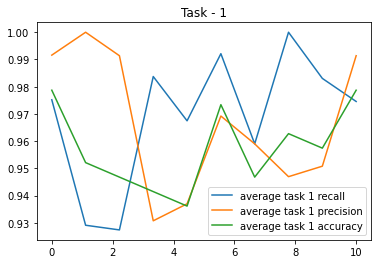

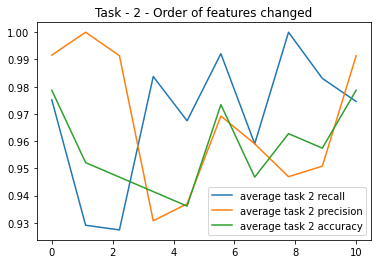

In [6]:
x = np.linspace(0, 10, 10)

plt.plot(x,results1[:,0],label = "average task 1 recall")
plt.plot(x,results1[:,1],label = "average task 1 precision")
plt.plot(x,results1[:,2],label = "average task 1 accuracy")
plt.legend()
plt.title("Task - 1")
plt.show()
plt.plot(x,results2[:,0],label = "average task 2 recall")
plt.plot(x,results2[:,1],label = "average task 2 precision")
plt.plot(x,results2[:,2],label = "average task 2 accuracy")
plt.legend()
plt.title("Task - 2 - Order of features changed")
plt.show()



In [7]:

print(results1.mean(axis =0),results2.mean(axis =0))

print(results1.var(axis =0),results2.var(axis =0))


[0.96917488 0.96681689 0.95744681] [0.96917488 0.96681689 0.95744681]
[0.00054001 0.00058263 0.00021503] [0.00054001 0.00058263 0.00021503]
